In [2]:
from ROOT import *
from root_numpy import tree2array
from ROOT import TFile
import pandas as pd
import numpy as np
import deepdish.io as io
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.advanced_activations import PReLU
from keras.utils import np_utils
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RandomizedLasso
import os
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

In [3]:
data = TFile.Open("/home/minerva1993/public/v808/nosplit/ttHbb_PowhegPythia.root")
data2 = TFile.Open("/home/minerva1993/public/v808/nosplit/TTLJ_PowhegPythia_ttbb.root")
tree = data.Get("ttbbLepJets/tree")
tree2 = data2.Get("ttbbLepJets/tree")

In [4]:
def tree_to_df(tree, branch_names=[], index_name='', drop_roofit_labels=False):
    if tree is None:
        return None

    branch_list = tree.GetListOfBranches()
    all_branch_names = [branch_list.At(i).GetName() for i in range(branch_list.GetEntries())]
    if len(branch_names) == 0:
        branch_names = all_branch_names
    for bn in branch_names[:]:
        if bn not in all_branch_names:
            branch_names.remove(bn)
        if drop_roofit_labels:
            if bn.endswith('_lbl'):
                branch_names.remove(bn)

    arrs = tree2array(tree, branch_names, start = 0, stop = 40000)
    df = pd.DataFrame(arrs)

    if len(index_name) == 0:
        for col in df.columns:
            if col.startswith('__index__'):
                index_name = col
                break
    if len(index_name):
        try:
            df[index_name] = df[index_name].astype(np.int32)
            df.set_index(index_name, inplace=True)
        except BaseException:
            pass

    if drop_roofit_labels:
        df.columns = [col.replace('_idx', '') for col in df.columns]

    n_tree = tree.GetEntries()
    n_df = len(df.index)

    return df 

In [5]:
dftree = tree_to_df(tree)
dftree_bg = tree_to_df(tree2)

In [6]:
# results = []
# for i in range(len(dftree['addbjet1_pt'])):
#     k = np.sqrt((dftree['addbjet1_e'][i] + dftree['addbjet2_e'][i])**2 - (dftree['addbjet1_pt'][i] + dftree['addbjet2_pt'][i])**2 - (dftree['addbjet1_eta'][i] + dftree['addbjet2_eta'][i])**2 - (dftree['addbjet1_phi'][i] + dftree['addbjet2_phi'][i])**2)
#     results.append(k)

In [7]:
#jet_CSV > 0.8
#number of bjets
#number of jets
#sum of csv (jet_csv 3rd 4th)

In [33]:
def process(df):
    columns = ['draddjets','lepton_pT','lepton_eta','lepton_phi','lepton_E','MET','MET_phi','jet_number','event_weight','delta_phi','delta_eta','delta_R','invmass','b_jet','csv_sum']
    
    for t in range(1,5):
        for i in ['jet_pT','jet_eta','jet_phi','jet_E','jet_CvsB']:
            columns.append(i+'_'+str(t))
    
    end = []
    
    for i in range(len(df['lepton_SF'])):
        if df['jet_number'][i] >= 6:
            parts = []
            for t in ['draddjets','lepton_pT','lepton_eta','lepton_phi','lepton_E','MET','MET_phi','jet_number']:
                parts.append(df[t][i])
            
            product = df['lepton_SF'][i][0] * df['jet_SF_CSV_30'][i][0] * df['PUWeight'][i][0] * df['genweight'][i]
            
            parts.append(product)
            
            x = df['jet_phi'][i][0] - df['jet_phi'][i][1]
            if x > math.pi:
                delta_phi = x - 2*math.pi
            elif x < -math.pi:
                delta_phi = x + 2*math.pi
            else:
                delta_phi = x
            delta_eta = df['jet_eta'][i][0] - df['jet_eta'][i][1]
            delta_R = math.sqrt(delta_phi**2 + delta_eta**2)
            
            pt1, pt2 = math.fabs(df['jet_pT'][i][0]), math.fabs(df['jet_pT'][i][3])
            pX1, pX2 = pt1 * math.cos(df['jet_phi'][i][0]), pt2 * math.cos(df['jet_phi'][i][3])
            pY1, pY2 = pt1 * math.sin(df['jet_phi'][i][0]), pt2 * math.sin(df['jet_phi'][i][3])
            pZ1, pZ2 = pt1 / math.tan(2.0 * math.atan(math.exp(-df['jet_eta'][i][0]))), pt2 / math.tan(2.0 * math.atan(math.exp(-df['jet_eta'][i][3])))
            invmass = math.sqrt((df['jet_E'][i][0] + df['jet_E'][i][3])**2 - (pX1 + pX2)**2 - (pY1 + pY2)**2 - (pZ1 + pZ2)**2)
            
            parts += [delta_phi, delta_eta, delta_R, invmass, sum([1 for t in df['jet_CSV'][i] if t > 0.8]), df['jet_CSV'][i][2] + df['jet_CSV'][i][3]]
            
            for t in range(len(df['jet_pT'][i])):
                passed = True
                partial = []
                for k in ['jet_pT','jet_eta','jet_phi','jet_E','jet_CvsB']:
                    if k == 'jet_pT':
                        if df[k][i][t] < 30:
                            passed = False
                            break
                    elif k == 'jet_eta':
                        if df[k][i][t] > 2.4 or df[k][i][t] < -2.4:
                            passed = False
                            break
                    partial.append(df[k][i][t])
                
                if passed:
                    parts += partial
                    
                if len(parts) == len(columns):
                    break
                    
            end.append(parts)
            
    print "Column Length: ", len(end[0])
    print "Fixed Length: ", len(columns)
    train_tree = pd.DataFrame(end, columns=columns)
    return train_tree

In [34]:
# overall = [ [[],[]] for i in range(6) ]
# for i in range(len(dftree['lepton_SF'])):
#     if dftree['jet_number'][i] >= 6:
#         count = 0
#         for t in [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]:
#             x = dftree['jet_phi'][i][t[0]] - dftree['jet_phi'][i][t[1]]
#             if x > math.pi:
#                 delta_phi = x - 2*math.pi
#             elif x < -math.pi:
#                 delta_phi = x + 2*math.pi
#             else:
#                 delta_phi = x
#             delta_eta = dftree['jet_eta'][i][t[0]] - dftree['jet_eta'][i][t[1]]
#             delta_R = math.sqrt(delta_phi**2 + delta_eta**2)
#             invmass = math.sqrt((dftree['jet_E'][i][t[0]] + dftree['jet_E'][i][t[1]])**2 - (dftree['jet_pT'][i][t[0]] + dftree['jet_pT'][i][t[1]])**2 - (dftree['jet_phi'][i][t[0]] + dftree['jet_phi'][i][t[1]])**2 - (dftree['jet_eta'][i][t[0]] + dftree['jet_eta'][i][t[1]])**2)
#             overall[count][0].append(delta_R)
#             overall[count][1].append(invmass)
#             count += 1

In [35]:
# overall_2 = [ [[],[]] for i in range(6) ]
# for i in range(len(dftree_bg['lepton_SF'])):
#     if dftree_bg['jet_number'][i] >= 6:
#         count = 0
#         for t in [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]:
#             x = dftree_bg['jet_phi'][i][t[0]] - dftree_bg['jet_phi'][i][t[1]]
#             if x > math.pi:
#                 delta_phi = x - 2*math.pi
#             elif x < -math.pi:
#                 delta_phi = x + 2*math.pi
#             else:
#                 delta_phi = x
#             delta_eta = dftree_bg['jet_eta'][i][t[0]] - dftree_bg['jet_eta'][i][t[1]]
#             delta_R = math.sqrt(delta_phi**2 + delta_eta**2)
#             invmass = math.sqrt((dftree_bg['jet_E'][i][t[0]] + dftree_bg['jet_E'][i][t[1]])**2 - (dftree_bg['jet_pT'][i][t[0]] + dftree_bg['jet_pT'][i][t[1]])**2 - (dftree_bg['jet_phi'][i][t[0]] + dftree_bg['jet_phi'][i][t[1]])**2 - (dftree_bg['jet_eta'][i][t[0]] + dftree_bg['jet_eta'][i][t[1]])**2)
#             overall_2[count][0].append(delta_R)
#             overall_2[count][1].append(invmass)
#             count += 1

In [36]:
# for i in range(len(overall)):
#     print "Significance of delta R: ", ks_2samp(np.array(overall[i][0]), overall_2[i][0])
#     print "Significance of invmass: ", ks_2samp(np.array(overall[i][1]), overall_2[i][1])

In [37]:
train_tree = process(dftree)

Column Length:  35
Fixed Length:  35


In [38]:
train_tree_2 = process(dftree_bg)

Column Length:  35
Fixed Length:  35


In [39]:
train_tree['result'] = np.zeros(len(train_tree))

In [40]:
train_tree_2['result'] = [1 for i in range(len(train_tree_2))]

In [41]:
full_train_res = train_tree.append(train_tree_2, ignore_index=True)

In [42]:
y_pred = full_train_res['result']
full_train = full_train_res.drop('result',1)

In [43]:
def preprocess_data(X, scaler=None):
    if not scaler:
        scaler = StandardScaler()
        scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler

In [44]:
train, scaler = preprocess_data(full_train)

/home/9304220184/python27/lib/python2.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


# Data Analysis and Cleaning

In [45]:
def get_delta_R(df,column1, column2, column3, column4):
    delta_R = [math.sqrt(df[column1][i] - df[column2][i])**2 + (df[column3][i] - df[column4][i])**2 for i in range(len(df[column1]))]
    return delta_R

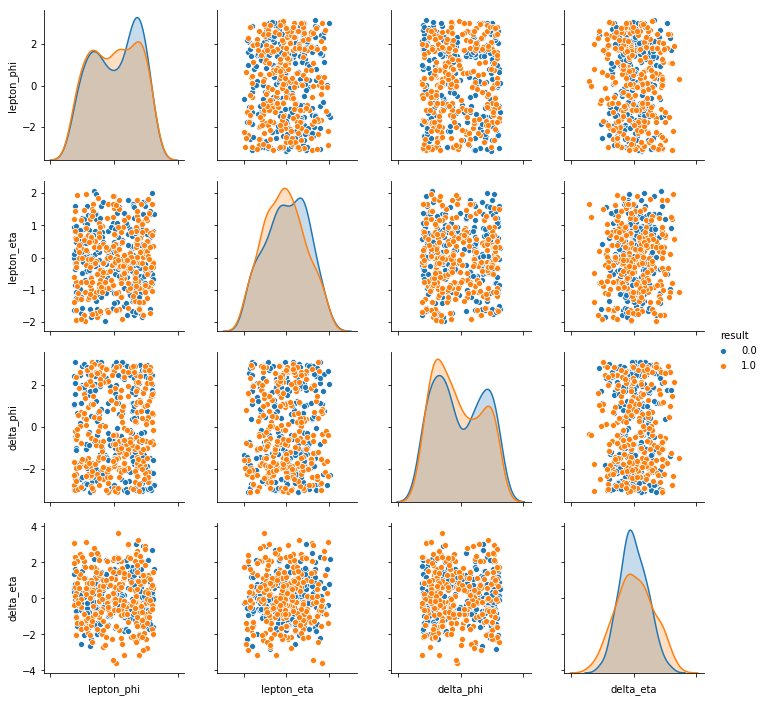

In [46]:
g = sns.pairplot(full_train_res.sample(500), vars=["lepton_phi","lepton_eta","delta_phi","delta_eta"], hue="result")
g.set(xticklabels=[]);

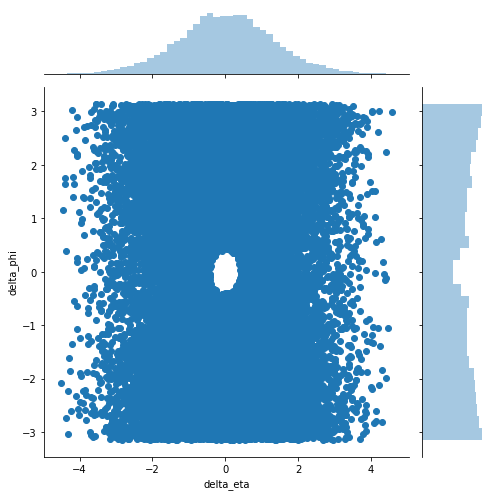

In [47]:
sns.jointplot(full_train_res.delta_eta, full_train_res.delta_phi, kind="scatter", height=7)
plt.show()

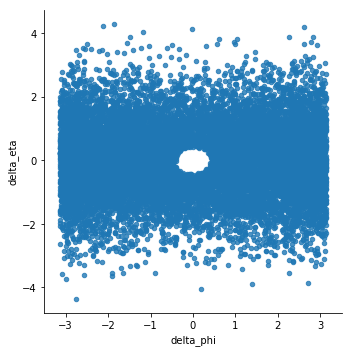

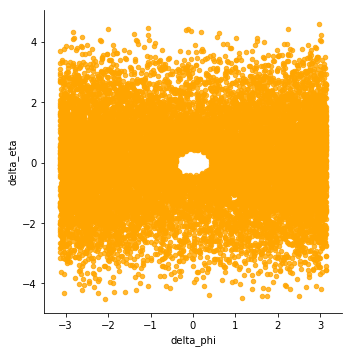

In [48]:
sns.lmplot(x='delta_phi', y='delta_eta', data=train_tree, fit_reg=False, scatter_kws={"s": 20})
sns.lmplot(x='delta_phi', y='delta_eta', data=train_tree_2, fit_reg=False, scatter_kws={"s": 20, 'color':'orange'})

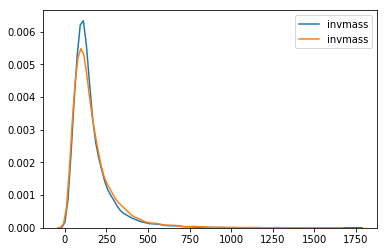

In [52]:
sns.kdeplot(train_tree.invmass)
sns.kdeplot(train_tree_2.invmass)
plt.show()

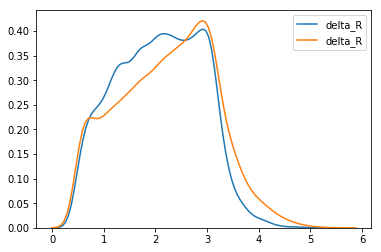

In [53]:
sns.kdeplot(train_tree.delta_R)
sns.kdeplot(train_tree_2.delta_R)
plt.show()

In [54]:
ranks = {}
colnames = full_train.columns
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [55]:
estimator = LinearRegression(normalize=True)
selector = RFE(estimator, n_features_to_select = 1, verbose = 3)
selector = selector.fit(train, y_pred)
ranks["RFE"] = ranking(list(map(float, selector.ranking_)), colnames, order=-1)

Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 feat

In [56]:
# Using Ridge 
ridge = Ridge(alpha = 7)
ridge.fit(train, y_pred)
ranks['Ridge'] = ranking(np.abs(ridge.coef_), colnames)

# Using Lasso
lasso = Lasso(alpha=.05)
lasso.fit(train, y_pred)
ranks["Lasso"] = ranking(np.abs(lasso.coef_), colnames)

In [57]:
rf = RandomForestClassifier(n_estimators=100, max_features=15, max_depth=11, random_state=1)
rf.fit(train, y_pred)
ranks["RF"] = ranking(rf.feature_importances_, colnames);

In [58]:
r = {}
for name in colnames:
    r[name] = round(np.mean([ranks[method][name] for method in ranks.keys()]), 2)

methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")

**Feature Selection Insights**

Lasso: Pick out top performing features and force the rest to be zero

RF: Sharp drop-off score after first few top ones

Ridge: Forces regression score to spread out similarly between correlated variables

RFE: Compromise between data interpretation and top feature selection for model improvement

In [59]:
print "\t\t", "\t".join(methods)
for name in colnames:
    nameit = name
    if len(name) == 3:
        nameit += "\t"
    print nameit, "\t","\t".join(map(str,[ranks[method][name] for method in methods]))

		Lasso	RF	RFE	Ridge	Mean
draddjets 	0.0	0.41	0.32	0.06	0.2
lepton_pT 	0.0	0.15	0.56	0.19	0.23
lepton_eta 	0.0	0.22	0.18	0.02	0.1
lepton_phi 	0.0	0.15	0.21	0.02	0.1
lepton_E 	0.0	0.15	0.38	0.06	0.15
MET		0.0	0.16	0.29	0.04	0.12
MET_phi 	0.0	0.16	0.12	0.02	0.07
jet_number 	0.0	0.03	0.76	0.26	0.26
event_weight 	0.0	0.28	0.68	0.24	0.3
delta_phi 	0.0	0.14	0.24	0.03	0.1
delta_eta 	0.0	1.0	0.41	0.08	0.37
delta_R 	0.0	0.69	0.82	0.48	0.5
invmass 	0.0	0.29	0.79	0.43	0.38
b_jet 	0.0	0.0	0.06	0.0	0.01
csv_sum 	0.0	0.14	0.62	0.37	0.28
jet_pT_1 	0.0	0.44	1.0	1.0	0.61
jet_eta_1 	0.0	0.26	0.47	0.14	0.22
jet_phi_1 	0.0	0.14	0.03	0.0	0.04
jet_E_1 	0.0	0.15	0.97	0.56	0.42
jet_CvsB_1 	0.0	0.15	0.53	0.13	0.2
jet_pT_2 	0.0	0.3	0.94	0.7	0.48
jet_eta_2 	0.0	0.27	0.44	0.09	0.2
jet_phi_2 	0.0	0.15	0.0	0.0	0.04
jet_E_2 	0.0	0.18	0.91	0.65	0.44
jet_CvsB_2 	0.0	0.16	0.65	0.18	0.25
jet_pT_3 	0.0	0.19	0.85	0.48	0.38
jet_eta_3 	0.0	0.34	0.26	0.03	0.16
jet_phi_3 	0.0	0.15	0.09	0.01	0.06
jet_E_3 	0.0	0.18	0.88	0.55	0.

In [60]:
# Put the mean scores into a Pandas dataframe
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

# Sort the dataframe
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)

/home/9304220184/python27/local/lib/python2.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


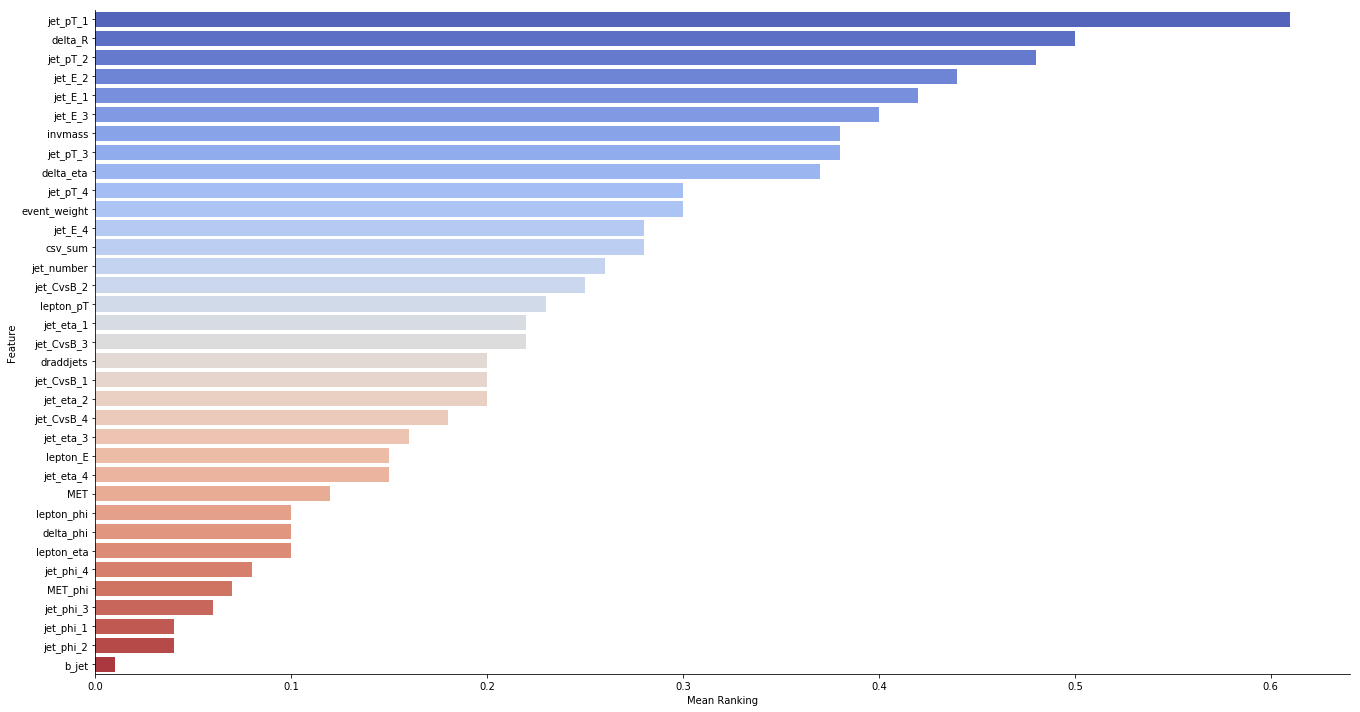

In [61]:
sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar", height=10, aspect=1.9, palette='coolwarm')

In [62]:
X_train, X_temp, Y_train, Y_temp = train_test_split(train, y_pred, test_size = 0.4, random_state = 42)

In [63]:
X_valid, X_test, Y_valid, Y_test = train_test_split(X_temp, Y_temp, test_size = 0.4, random_state = 42)

# Neural Networks

In [64]:
model = Sequential()
model.add(Dropout(0.13, input_shape=(X_train.shape[1],)))
model.add(Dense(75))
model.add(PReLU())

model.add(Dropout(0.11))
model.add(Dense(60))
model.add(PReLU())

model.add(Dropout(0.09))
model.add(Dense(45))
model.add(PReLU())

model.add(Dropout(0.07))
model.add(Dense(30))
model.add(PReLU())

model.add(Dropout(0.11))
model.add(Dense(15))
model.add(PReLU())

model.add(Dense(2))
model.add(Activation('sigmoid'))

In [65]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(lr=0.05, nesterov=True), metrics=['accuracy'])

In [66]:
Y_train_nn = np_utils.to_categorical(Y_train)
Y_valid_nn = np_utils.to_categorical(Y_valid)

In [67]:
model.fit(X_train, Y_train_nn, batch_size=64, epochs=70, verbose=2, shuffle=True, validation_data = (X_valid, Y_valid_nn))

Train on 18136 samples, validate on 7254 samples
Epoch 1/70
 - 2s - loss: 0.6947 - acc: 0.5055 - val_loss: 0.6910 - val_acc: 0.5230
Epoch 2/70
 - 1s - loss: 0.6912 - acc: 0.5268 - val_loss: 0.6884 - val_acc: 0.5436
Epoch 3/70
 - 1s - loss: 0.6884 - acc: 0.5385 - val_loss: 0.6862 - val_acc: 0.5532
Epoch 4/70
 - 1s - loss: 0.6872 - acc: 0.5432 - val_loss: 0.6829 - val_acc: 0.5587
Epoch 5/70
 - 1s - loss: 0.6842 - acc: 0.5503 - val_loss: 0.6820 - val_acc: 0.5611
Epoch 6/70
 - 1s - loss: 0.6814 - acc: 0.5641 - val_loss: 0.6789 - val_acc: 0.5660
Epoch 7/70
 - 1s - loss: 0.6808 - acc: 0.5619 - val_loss: 0.6768 - val_acc: 0.5671
Epoch 8/70
 - 1s - loss: 0.6794 - acc: 0.5668 - val_loss: 0.6775 - val_acc: 0.5669
Epoch 9/70
 - 1s - loss: 0.6758 - acc: 0.5750 - val_loss: 0.6739 - val_acc: 0.5740
Epoch 10/70
 - 1s - loss: 0.6759 - acc: 0.5727 - val_loss: 0.6727 - val_acc: 0.5787
Epoch 11/70
 - 1s - loss: 0.6746 - acc: 0.5803 - val_loss: 0.6723 - val_acc: 0.5837
Epoch 12/70
 - 1s - loss: 0.6727 - a

2018-10-25 15:29:31.235925: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


# Gradient Boosting

In [86]:
Y_train = np.array(Y_train)
Y_valid = np.array(Y_valid)
xgb = XGBRegressor()

In [69]:
params={
    'objective': 'binary:logistic',
    'learning_rate': 0.1,
    'max_depth':5,
    'gamma': 0.3,
    'min_child_weight':1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_estimators': 1000,
}

In [70]:
# grs = GridSearchCV(xgb, param_grid=params, cv=2, n_jobs=4, verbose=2)
# grs.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], verbose=False)

# print("Best parameters " + str(grs.best_params_))
# gpd = pd.DataFrame(grs.cv_results_)
# print("Estimated accuracy of this model for unseen data: {0:1.4f}".format(gpd['mean_test_score'][grs.best_index_]))

In [71]:
my_model = XGBRegressor(
    objective = 'binary:logistic',
    learning_rate = 0.1,
    max_depth = 5,
    gamma = 0,
    min_child_weight = 1,
    subsample = 0.8,
    colsample_bytree = 0.8,
    n_estimators = 1000,
    silent = 1
)

In [72]:
my_model.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
       subsample=0.8)

In [73]:
a = my_model.predict(X_valid)

In [74]:
Y_valid = np.array(Y_valid)

In [75]:
print("Accuracy for Gradient Boosting: %.2f" % (accuracy_score(Y_valid, a.round()) * 100))

Accuracy for Gradient Boosting: 59.64


# Random Forest

In [76]:
rf = RandomForestClassifier(n_estimators=100, max_features=15, max_depth=11, random_state=1)
rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features=15, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [77]:
r = rf.predict(X_valid)
Y_valid = np.array(Y_valid)
print("Accuracy for Random Forest: %.2f" % (accuracy_score(Y_valid, r.round()) * 100))

Accuracy for Random Forest: 59.58


In [78]:
r_train = rf.predict(X_train)
Y_train = np.array(Y_train)
print("Training Accuracy for Random Forest: %.2f" % (accuracy_score(Y_train, r_train.round()) * 100))

Training Accuracy for Random Forest: 82.22


# Combining Models

In [79]:
Y_test = np.array(Y_test)

In [80]:
nn_test = model.predict(X_test)
gb_test = my_model.predict(X_test)
r_test = rf.predict(X_test)

In [81]:
nn_test = np.array([i[1] for i in nn_test])

In [82]:
precision_recall_fscore_support(Y_test, (nn_test*0.4 + gb_test*0.3 + r_test*0.3).round())

(array([0.60935143, 0.62334096]),
 array([0.66256663, 0.56797331]),
 array([0.63484581, 0.5943705 ]),
 array([2439, 2398]))

# ROC Curve

In [83]:
y_prob = nn_test*0.4 + gb_test*0.3 + r_test*0.3

In [84]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

Text(0.5,0,'False Positive Rate')

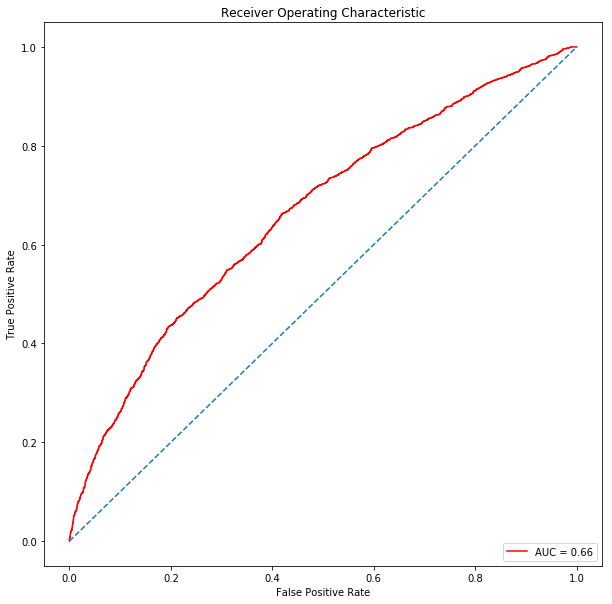

In [85]:
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')